In [1]:
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf

from datetime import datetime
from sklearn import metrics

2025-10-30 14:22:52.475484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761826972.488496 4176479 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761826972.493071 4176479 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761826972.503033 4176479 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761826972.503049 4176479 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761826972.503050 4176479 computation_placer.cc:177] computation placer alr

### Load Teff and log(Y) values for sample

Teff and log(Y) from Culpan et. al (2022), VizieR table J/A+A/662/A40/knownhsd.

In [2]:
data = pd.read_csv("data/known_sds_Teff_logY.csv")
data

,GaiaEDR3,Teff,logY
0,1792620565667968,NaN,NaN
1,3018713469617920,39190.0,-0.19
2,3101962820420608,NaN,NaN
3,5256284056331776,NaN,NaN
4,6052403489630720,36414.0,0.38
...,...,...,...
6588,6913910539170818816,NaN,NaN
6589,6914322576858227968,31600.0,-3.00
6590,6914530384555510656,NaN,NaN
6591,6914533614371729536,NaN,NaN


#### Remove hot sds with missing values

In [3]:
data = data.dropna()
data

,GaiaEDR3,Teff,logY
1,3018713469617920,39190.0,-0.19
4,6052403489630720,36414.0,0.38
6,9132341717393792,30700.0,-2.40
8,11015044926034816,33853.0,-1.85
9,11963171843658240,41361.0,-2.85
...,...,...,...
6583,6913188263109953920,49669.0,2.24
6584,6913349543425935232,35133.0,-1.40
6585,6913373354725177472,33550.0,-1.80
6586,6913420603662102784,35500.0,-1.40


### Classify trainig sources, based on effecitve temperature and He abundance

if (Teff < 35000) & (logY < -1): label = 1 (sdB)

else: label = 0 (not sdB)

In [4]:
# Initialize the "label" column with zeros
data["label"] = 0

# Apply condition: Teff < 35000 and logY < -1
theshold_Teff = 35000
threshold_logY = -1
condition = (data["Teff"] < theshold_Teff) & (data["logY"] < threshold_logY)
data.loc[condition, "label"] = 1

data

/tmp/ipykernel_4176479/973519073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = 0


,GaiaEDR3,Teff,logY,label
1,3018713469617920,39190.0,-0.19,0
4,6052403489630720,36414.0,0.38,0
6,9132341717393792,30700.0,-2.40,1
8,11015044926034816,33853.0,-1.85,1
9,11963171843658240,41361.0,-2.85,0
...,...,...,...,...
6583,6913188263109953920,49669.0,2.24,0
6584,6913349543425935232,35133.0,-1.40,0
6585,6913373354725177472,33550.0,-1.80,1
6586,6913420603662102784,35500.0,-1.40,0


#### Plot classes in Teff-logY diagram

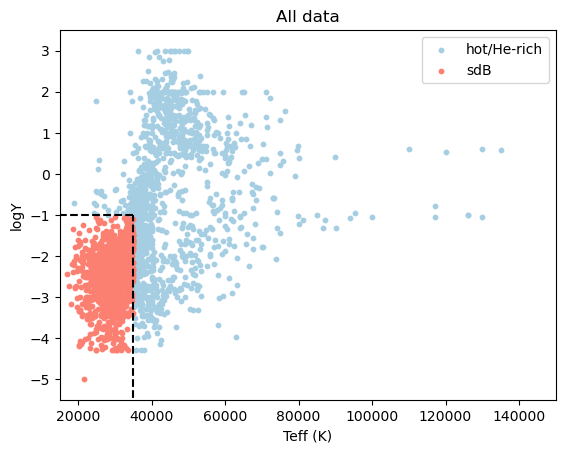

In [5]:
plt.title("All data")

# Hot/He-rich
plt.scatter(data[data["label"] == 0]["Teff"],
            data[data["label"] == 0]["logY"],
            s=10, color="#a6cee3", label="hot/He-rich")

# sdB
plt.scatter(data[data["label"] == 1]["Teff"],
            data[data["label"] == 1]["logY"],
            s=10, color="#fb8072", label="sdB")

plt.plot([theshold_Teff, theshold_Teff], [-6, threshold_logY], color="black", linestyle="--")
plt.plot([theshold_Teff, 0], [threshold_logY, threshold_logY], color="black", linestyle="--")

plt.xlabel("Teff (K)")
plt.ylabel("logY")

plt.xlim(15000, 150000)
plt.ylim(-5.5, 3.5)


plt.legend()
plt.show()

### Load normalized XP spectra

In [6]:
filepath = "data/XP_spectra_norm.par"
all_fluxes = pd.read_parquet(filepath)
print(filepath)

# Extract names of wavelength columns and the wavelength values
column_names = all_fluxes.columns.values
wvl_columns = column_names[1:]
wvl_values = wvl_columns.astype("float64")

all_fluxes

data/XP_spectra_norm.par


,GaiaEDR3,400.0,402.0,404.0,406.0,408.0,410.0,412.0,414.0,416.0,...,932.0,934.0,936.0,938.0,940.0,942.0,944.0,946.0,948.0,950.0
0,1306361548360576,0.853450,0.941675,1.000411,0.988710,0.925614,0.866464,0.855969,0.900321,0.961643,...,0.993973,0.998679,1.000135,0.999833,0.991327,0.981020,0.982047,0.970091,0.965854,0.977762
1,1792620565667968,0.959502,0.996733,1.000108,0.975493,0.947082,0.936094,0.946869,0.972096,0.992361,...,0.989064,0.997809,1.000719,0.999373,0.987119,0.970374,0.962181,0.938859,0.921021,0.916727
2,6052403489630720,0.974929,0.992400,1.000032,0.988859,0.966801,0.948620,0.943953,0.955887,0.972213,...,0.988757,0.997123,1.000409,1.000030,0.989502,0.975452,0.971328,0.953621,0.943489,0.949665
3,6353119919810816,0.928566,0.980801,1.000170,0.977861,0.934958,0.903505,0.902977,0.933175,0.970096,...,0.988380,0.996614,1.000155,1.000293,0.990562,0.977249,0.973427,0.955111,0.943117,0.945857
4,10844075163628928,0.927307,0.984887,1.000189,0.971341,0.927670,0.903547,0.913471,0.949748,0.984329,...,0.990076,0.997219,1.000149,1.000254,0.991048,0.978711,0.976138,0.958996,0.947835,0.950827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,6916087950150111232,0.953987,0.982351,0.993574,0.978676,0.942920,0.904479,0.884542,0.897774,0.934133,...,0.990458,0.997577,1.000323,1.000104,0.990335,0.977298,0.974000,0.956321,0.944928,0.948095
20070,6916186184642798848,0.944458,0.990766,1.000156,0.973015,0.936448,0.919586,0.932130,0.964952,0.992000,...,0.937379,0.953363,0.968575,0.982308,0.986486,0.986290,0.994723,0.987531,0.986288,1.000191
20071,6916517859197240320,0.965473,0.982872,0.990037,0.976551,0.944274,0.908453,0.889263,0.902068,0.937744,...,0.990237,0.997536,1.000324,1.000031,0.990184,0.977328,0.974813,0.958878,0.950554,0.958498
20072,6916925361398340096,0.969359,0.985898,1.000018,0.998645,0.979826,0.953819,0.936201,0.940956,0.961661,...,0.988196,0.996699,1.000288,1.000183,0.989802,0.975520,0.970561,0.951265,0.938701,0.941522


#### Keep only sources that are in "data" and add labels to fluxes data frame

In [7]:
# Merge "data" and "all_fluxes" DataFrames on the "GaiaEDR3" column
fluxes = pd.merge(data, all_fluxes, on="GaiaEDR3")

# Display the merged DataFrame
fluxes

,GaiaEDR3,Teff,logY,label,400.0,402.0,404.0,406.0,408.0,410.0,...,932.0,934.0,936.0,938.0,940.0,942.0,944.0,946.0,948.0,950.0
0,6052403489630720,36414.0,0.38,0,0.974929,0.992400,1.000032,0.988859,0.966801,0.948620,...,0.988757,0.997123,1.000409,1.000030,0.989502,0.975452,0.971328,0.953621,0.943489,0.949665
1,11015044926034816,33853.0,-1.85,1,0.951933,0.991996,1.000114,0.977713,0.945763,0.927086,...,0.990638,0.997393,1.000133,1.000203,0.991118,0.979140,0.977299,0.961396,0.952156,0.957959
2,11963171843658240,41361.0,-2.85,0,0.952121,0.993361,1.000120,0.976296,0.944764,0.927838,...,0.990996,0.997503,1.000115,1.000291,0.991548,0.979929,0.978120,0.961453,0.950203,0.952289
3,13746369248366848,34920.0,-1.65,1,0.930601,0.981438,1.000138,0.980689,0.942526,0.913726,...,0.990885,0.997216,0.999882,1.000337,0.992174,0.981427,0.980783,0.965463,0.955725,0.959497
4,16615171179593088,26600.0,-2.70,1,0.912644,0.977184,1.000207,0.974613,0.927038,0.893910,...,0.991340,0.997474,1.000002,1.000332,0.992019,0.981085,0.980231,0.964736,0.954927,0.958814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,6899029954958005248,31152.0,-1.60,1,0.879913,0.957781,1.000319,0.981732,0.924425,0.875732,...,0.990980,0.997810,1.000366,1.000053,0.990231,0.977171,0.973876,0.956228,0.944905,0.948200
1987,6906152621346929280,59920.0,0.39,0,0.985627,0.993220,0.989310,0.986599,0.991641,0.999527,...,0.989498,0.997262,1.000301,1.000086,0.990227,0.977309,0.974709,0.958677,0.950231,0.957990
1988,6913349543425935232,35133.0,-1.40,0,0.887790,0.960442,1.000335,0.982264,0.927924,0.882868,...,0.992510,0.999310,1.000636,0.997920,0.984483,0.966772,0.957909,0.934546,0.917514,0.915180
1989,6913373354725177472,33550.0,-1.80,1,0.958093,0.995355,1.000104,0.976282,0.947096,0.934684,...,0.988506,0.996799,1.000274,1.000166,0.989917,0.975943,0.971515,0.952981,0.941437,0.945571


#### Plot classes in Teff-logY diagram

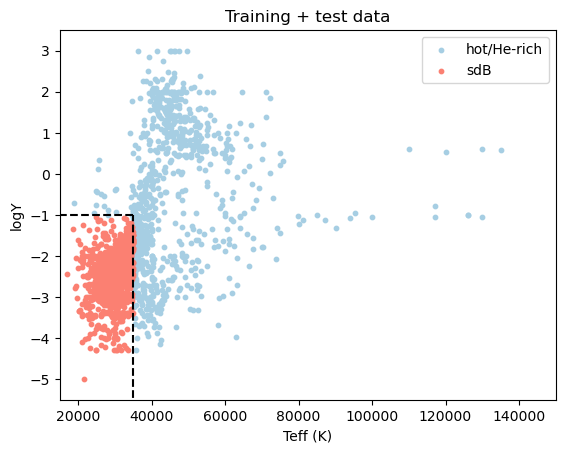

In [8]:
plt.title("Training + test data")

plt.scatter(fluxes[fluxes["label"] == 0]["Teff"],
            fluxes[fluxes["label"] == 0]["logY"],
            s=10, color="#a6cee3", label="hot/He-rich")

plt.scatter(fluxes[fluxes["label"] == 1]["Teff"],
            fluxes[fluxes["label"] == 1]["logY"],
            s=10, color="#fb8072", label="sdB")

plt.plot([theshold_Teff, theshold_Teff], [-6, threshold_logY], color="black", linestyle="--")
plt.plot([theshold_Teff, 0], [threshold_logY, threshold_logY], color="black", linestyle="--")

plt.xlabel("Teff (K)")
plt.ylabel("logY")

plt.xlim(15000, 150000)
plt.ylim(-5.5, 3.5)


plt.xlabel("Teff (K)")
plt.ylabel("logY")
plt.legend()
plt.show()

### Define training, validation, and test sets for CNN training and testing

In [9]:
def pick_test_set(fluxes, n_test):
    """
    Randomly splits the input DataFrame into a test set and a remaining set.

    Parameters:
        fluxes (pd.DataFrame): The full dataset containing a 'GaiaEDR3' column.
        n_test (int): Number of samples to include in the test set.

    Returns:
        tuple: (fluxes_test, fluxes_train_val)
            - fluxes_test: Randomly selected test samples.
            - fluxes_train_val: Remaining samples not in the test set.
    """
    # Randomly select N_test rows for the test set
    fluxes_test = fluxes.sample(n_test, ignore_index=True)

    # Exclude test set rows from the original DataFrame
    fluxes_train_val = fluxes[~fluxes["GaiaEDR3"].isin(fluxes_test["GaiaEDR3"])]

    return fluxes_test, fluxes_train_val


In [10]:
def make_train_val(fluxes, n_val):
    """
    Splits the input DataFrame into a validation set and a training set.

    Parameters:
        fluxes (pd.DataFrame): The dataset to split, containing 'GaiaEDR3' column.
        n_val (int): Number of samples to include in the validation set.

    Returns:
        tuple: (fluxes_train, fluxes_val)
            - fluxes_train: Remaining samples after validation selection.
            - fluxes_val: Randomly selected validation samples.
    """
    # Randomly select N_val rows for the validation set
    fluxes_val = fluxes.sample(n_val, ignore_index=True)

    # Remaining samples form the training set
    fluxes_train = fluxes[~fluxes["GaiaEDR3"].isin(fluxes_val["GaiaEDR3"])]
    fluxes_train = fluxes_train.reset_index(drop=True)

    return fluxes_train, fluxes_val


In [12]:
# Define test and validation set sizes
n_test = 250
n_val = 250

# Split the dataset
fluxes_test, fluxes_train_val = pick_test_set(fluxes, n_test)
fluxes_train, fluxes_val = make_train_val(fluxes_train_val, n_val)

# Training set summary
print(f"Training set: {len(fluxes_train)}")
n_sdb_train = (fluxes_train["label"] == 1).sum()
n_hotrich_train = (fluxes_train["label"] == 0).sum()
print(f"{n_hotrich_train} hot/rich")
print(f"{n_sdb_train} sdB ({n_sdb_train / len(fluxes_train) * 100:.0f}%)\n")

# Validation set summary
print(f"val set: {len(fluxes_val)}")
n_sdb_val = (fluxes_val["label"] == 1).sum()
n_hotrich_val = (fluxes_val["label"] == 0).sum()
print(f"{n_hotrich_val} hot/rich")
print(f"{n_sdb_val} sdB ({n_sdb_val / len(fluxes_val) * 100:.0f}%)\n")

# Test set summary
print(f"test set: {len(fluxes_test)}")
n_sdb_test = (fluxes_test["label"] == 1).sum()
n_hotrich_test = (fluxes_test["label"] == 0).sum()
print(f"{n_hotrich_test} hot/rich")
print(f"{n_sdb_test} sdB ({n_sdb_test / len(fluxes_test) * 100:.0f}%)\n")

Training set: 1476
683 hot/rich
793 sdB (54%)

val set: 250
113 hot/rich
137 sdB (55%)

test set: 250
112 hot/rich
138 sdB (55%)



### Build CNN architecture

In [13]:
def make_model():
    """
    Builds and returns a 1D CNN model for sdB classification of flux spectra.
    """
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(fluxes[wvl_columns].shape[1], 1)),
    
            tf.keras.layers.Conv1D(filters=16, kernel_size=5),
            tf.keras.layers.LeakyReLU(),
    
            tf.keras.layers.Conv1D(filters=16, kernel_size=5),
            tf.keras.layers.LeakyReLU(),
    
            tf.keras.layers.Conv1D(filters=16, kernel_size=5),
            tf.keras.layers.LeakyReLU(),
    
            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(256),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(32),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(16),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(8),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(4),
            tf.keras.layers.LeakyReLU(),
    
            tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    return model


### Training of CNN models

In [14]:
# Number of CNN models train in ensemble
n_models = 10

# Early stopping callback to halt training if validation loss doesn't improve
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              mode="min",
                                              patience=100,
                                              start_from_epoch=50,
                                              restore_best_weights=False)

for n in range(n_models):

    # Generate timestamped model path
    date_stamp = datetime.today().strftime('%Y-%m-%d')
    model_path = f"CNN_models/sdB_{date_stamp}_model_{n}.keras"

    # Checkpoint callback to save the best model during training
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                    monitor="val_loss",
                                                    mode="min",
                                                    save_best_only=True,
                                                    verbose=0)

    # Create new training and validation sets for this run
    fluxes_train, fluxes_val = make_train_val(fluxes_train_val, n_val)

    # Build and compile the CNN model
    model = make_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_accuracy"])

    # Train the model
    model.fit(x=fluxes_train[wvl_columns], y=fluxes_train["label"],
              validation_data=(fluxes_val[wvl_columns], fluxes_val["label"]),
              epochs=10000,
              batch_size=32,
              callbacks=[early_stop, checkpoint],
              verbose=2)

    print(f"Trained model saved to {model_path}")

Epoch 1/10000


2025-10-30 14:23:15.912065: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


47/47 - 2s - 46ms/step - binary_accuracy: 0.5341 - loss: 0.6918 - val_binary_accuracy: 0.5720 - val_loss: 0.6866
Epoch 2/10000
47/47 - 0s - 9ms/step - binary_accuracy: 0.5341 - loss: 0.6911 - val_binary_accuracy: 0.5720 - val_loss: 0.6840
Epoch 3/10000
47/47 - 0s - 9ms/step - binary_accuracy: 0.5341 - loss: 0.6922 - val_binary_accuracy: 0.5720 - val_loss: 0.6833
Epoch 4/10000
47/47 - 0s - 8ms/step - binary_accuracy: 0.5341 - loss: 0.6915 - val_binary_accuracy: 0.5720 - val_loss: 0.6890
Epoch 5/10000
47/47 - 0s - 7ms/step - binary_accuracy: 0.5341 - loss: 0.6910 - val_binary_accuracy: 0.5720 - val_loss: 0.6863
Epoch 6/10000
47/47 - 0s - 7ms/step - binary_accuracy: 0.5341 - loss: 0.6902 - val_binary_accuracy: 0.5720 - val_loss: 0.6837
Epoch 7/10000
47/47 - 0s - 8ms/step - binary_accuracy: 0.5341 - loss: 0.6890 - val_binary_accuracy: 0.5720 - val_loss: 0.6820
Epoch 8/10000
47/47 - 0s - 8ms/step - binary_accuracy: 0.5341 - loss: 0.6863 - val_binary_accuracy: 0.5720 - val_loss: 0.6740
Epoch

### Pick best models

In [ ]:
def get_model_losses(date_stamp, data_test, n_models):
    """
    Evaluate multiple Keras models and return their test losses.

    Parameters:
    - date_stamp (str): Date identifier used in model filenames.
    - data_test (DataFrame): Test dataset containing input features and target labels.
    - n_runs (int): Number of model runs to evaluate.

    Returns:
    - np.ndarray: Array of test losses for each model.
    """
    model_losses = []

    for n in range(n_models):
        # Construct the model file path
        model_path = f"CNN_models/sdB_{date_stamp}_model_{n}.keras"
        
        # Load the trained model
        model = keras.models.load_model(model_path)
        
        # Evaluate the model on the test set
        eval_loss = model.evaluate(
                                    data_test[wvl_columns],               # Input features
                                    data_test["label"],                   # Target labels
                                    batch_size=16,
                                    verbose=0)[0]

        print(f"Test loss of model {model_path}: {eval_loss:.4f}")
        model_losses.append(eval_loss)

    print("\nDisplayed losses do not have class weights.\n")

    return np.array(model_losses)

In [ ]:
# Parameters
date_stamp = "2025-10-30"
n_models = 10
n_keep = 5

# Evaluate models and get their losses for the test set
model_losses = get_model_losses(date_stamp, fluxes_test, n_models)

# Identify indices of the best-performing models (lowest losses)
i_best_models = np.argsort(model_losses)[:n_keep]

print(f"\nIndices of the {n_keep} best models: {i_best_models}")

### Evaluate best models.

In [ ]:
def eval_set(data_set, i_best_models, date_stamp):
    """
    Evaluate an ensemble of the best models on a given dataset.

    Parameters:
    - data_set (DataFrame): Dataset containing features and true labels.
    - i_best_models (list or array): Indices of the best-performing models.
    - date_stamp (str): Date identifier used in model filenames.

    Returns:
    - None (prints evaluation metrics)
    """
    
    # Initialize array to store predictions from each model
    predictions_runs = np.zeros((len(i_best_models), len(data_set)))

    for a, i in enumerate(i_best_models):
        # Construct model path using the index of the best model
        model_path = f"CNN_models/sdB_{date_stamp}_model_{n}.keras"
        
        # Load the model
        model = keras.models.load_model(model_path)
        
        # Predict and store the results
        predictions = model.predict(data_set[wvl_columns], verbose=0).flatten()
        predictions_runs[a, :] = predictions

    # Compute mean and standard deviation of predictions across models
    predictions_mean = np.mean(predictions_runs, axis=0)
    predictions_std = np.std(predictions_runs, axis=0)

    # Create a DataFrame to store predictions and true labels
    p = pd.DataFrame({"label": data_set["label"], "prediction": predictions_mean, "std": predictions_std})

    # Threshold that maximises F1 score
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(p["label"], p["prediction"])
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    max_f1_thresh = thresholds[np.argmax(f1_scores)]

    print(f"Threshold that maximizes F1: {max_f1_thresh:.3f}")
    print()
    print("With that threshold:")

    f1 = np.max(f1_scores)

    # Sensitivity, specificity, and precision
    p["predicted_label"] = 0
    p.loc[p["prediction"] > max_f1_thresh, "predicted_label"] = 1

    true_positive = ((p["predicted_label"] == 1) & (p["label"] == 1)).sum()
    false_positive = ((p["predicted_label"] == 1) & (p["label"] == 0)).sum()
    true_negative = ((p["predicted_label"] == 0) & (p["label"] == 0)).sum()
    false_negative = ((p["predicted_label"] == 0) & (p["label"] == 1)).sum()

    tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    tnr = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0
    ppv = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

    # Print results
    print()
    print(f"F1: {f1:.3f}")
    print(f"True Positive Rate (Sensitivity): {tpr:.3f}")
    print(f"True Negative Rate (Specificity): {tnr:.3f}")
    print(f"Positive Predictive Value (Precision): {ppv:.3f}")
    print()

In [ ]:
date_stamp = "2025-10-30"

print("Full set")
eval_set(fluxes, i_best_models, date_stamp)

### Network gradients for class sdB

In [ ]:
# --- Load the trained CNN model ---
model_path = f"CNN_models/sdB_{date_stamp}_model_{i_best_models[0]}.keras"
print(f"Loading model from: {model_path}")
model = keras.models.load_model(model_path)

# --- Prepare input fluxes for gradient calculation ---
# Convert selected flux columns to a TensorFlow variable
fluxes_watch = tf.Variable(fluxes[wavelength_cols], dtype='float32')

# --- Compute gradients of the model's predictions with respect to input fluxes ---
with tf.GradientTape() as tape:
    tape.watch(fluxes_watch)
    label_prediction = model(fluxes_watch, training=False)
    grad = tape.gradient(label_prediction, fluxes_watch)

# Average gradients across all input spectra
grad_sdB = np.mean(grad, axis=0)

# --- Compute the average spectrum ---
fluxes_mean = np.mean(fluxes[wavelength_cols], axis=0)

# --- Plot the average spectrum and the CNN gradients ---
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0.5)

# Plot mean spectrum
ax1.set_title("Mean Spectrum")
ax1.plot(wavelengths, fluxes_mean, color="black", lw=2)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Normalized Flux")
#ax1.set_xlim(400, 650)

# Plot CNN gradients
ax2.set_title("CNN Gradients for sdB")
ax2.plot(wavelengths.astype("float"), grad_sdB, color="black", lw=2)
ax2.axhline(0, color="black", linestyle="--")
ax2.set_xlabel("Wavelength (nm)")

plt.show()

### Predict labels for all sources

In [ ]:
def predict(fluxes, i_best_models, date_stamp):
    """
    Generate ensemble predictions and uncertainty estimates using the best models.

    Parameters:
    - fluxes (DataFrame): Input data for prediction.
    - i_best_models (list or array): Indices of the best-performing models.
    - date_stamp (str): Date identifier used in model filenames.

    Returns:
    - Tuple of np.ndarray: (mean predictions, standard deviation of predictions)
    """
    # Initialize array to store predictions from each model
    predictions_models = np.zeros((len(i_best_models), len(fluxes)))

    for a, i in enumerate(i_best_models):
        model_path = f"CNN_models/sdB_{date_stamp}_model_{i}.keras"
        print(f"Loading model: {model_path}")
        
        model = keras.models.load_model(model_path)
        predictions = model.predict(fluxes[wavelength_cols], verbose=0).flatten()
        predictions_models[a, :] = predictions

    # Return mean and standard deviation across model predictions
    return np.mean(predictions_models, axis=0), np.std(predictions_models, axis=0)


In [ ]:
# Load all normalized spectra
filepath = "data/XP_spectra_norm.par"
all_fluxes = pd.read_parquet(filepath)
print(filepath)

# Extract names of wavelength columns and the wavelength values
column_names = all_fluxes.columns.values
wvl_columns = column_names[1:]
wvl_values = wvl_columns.astype("float64")

date_stamp = "2025-10-29"
predictions_mean, predictions_std = predict(fluxes_all, i_best_models, date_stamp)

fluxes_all["P_sdB_CNN"] = predictions_mean
fluxes_all["std_sdB_CNN"] = predictions_std

### Save results to file

In [ ]:
filepath = "data/CNN_predictions_sdB.csv"

fluxes_all[["GaiaEDR3", "P_sdB_CNN", "std_sdB_CNN"]].to_csv(path_or_buf=filepath, index=False)

print(f"Label predictions saved to {filepath}")

In [ ]:
plt.scatter(fluxes_all["P_sdB_CNN"], fluxes_all["std_sdB_CNN"], s=1)